In [19]:
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import make_source_mask
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
from astropy.stats import SigmaClip
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)

In [20]:
# Opening the images
from PIL import Image
hdul = fits.open(
    '/Users/lucahartman/Documents/EPFL/ssa/proj-sem/psf-map-images/Light_ASIImg_10sec_Bin1_-10.0C_gain0_2022-05-14_230740_frame0004.fit')
hdul.info()

img = fits.getdata(
    '/Users/lucahartman/Documents/EPFL/ssa/proj-sem/psf-map-images/Light_ASIImg_10sec_Bin1_-10.0C_gain0_2022-05-14_230740_frame0004.fit')

from fonctions import *
bias = averageFolder('bias')
dark = averageFolder('dark')
flat = averageFolder('flat')

Filename: /Users/lucahartman/Documents/EPFL/ssa/proj-sem/psf-map-images/Light_ASIImg_10sec_Bin1_-10.0C_gain0_2022-05-14_230740_frame0004.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (6248, 4176)   int16 (rescales to uint16)   


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_7605/1607445073.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ca = plt.colorbar()


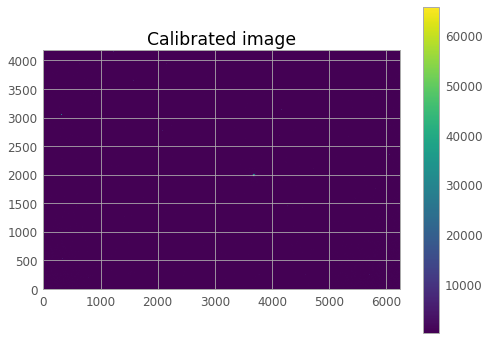

In [44]:
# Image calibrated using the different calibration frames
#from fonctions import *
image_clean = calibrate(img, bias, dark, flat)
#image_clean = image_clean - np.min(image_clean)
#image_clean = image_clean / np.max(image_clean) * (2**16-1)
plt.figure()
plt.title('Calibrated image')
plt.imshow(image_clean, origin='lower', cmap='viridis', interpolation='none')
ca = plt.colorbar()
plt.show()

BRUTE FORCE: mean, median, std = 991.6036313995958, 998.0, 40.030259899651256
CLIPPED: mean, median, std = 992.0915724046239, 1000.0, 43.91632515760944
MASKED: mean, median, std = 992.0727011258213, 999.0, 43.67452268925811


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_7605/2013415125.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


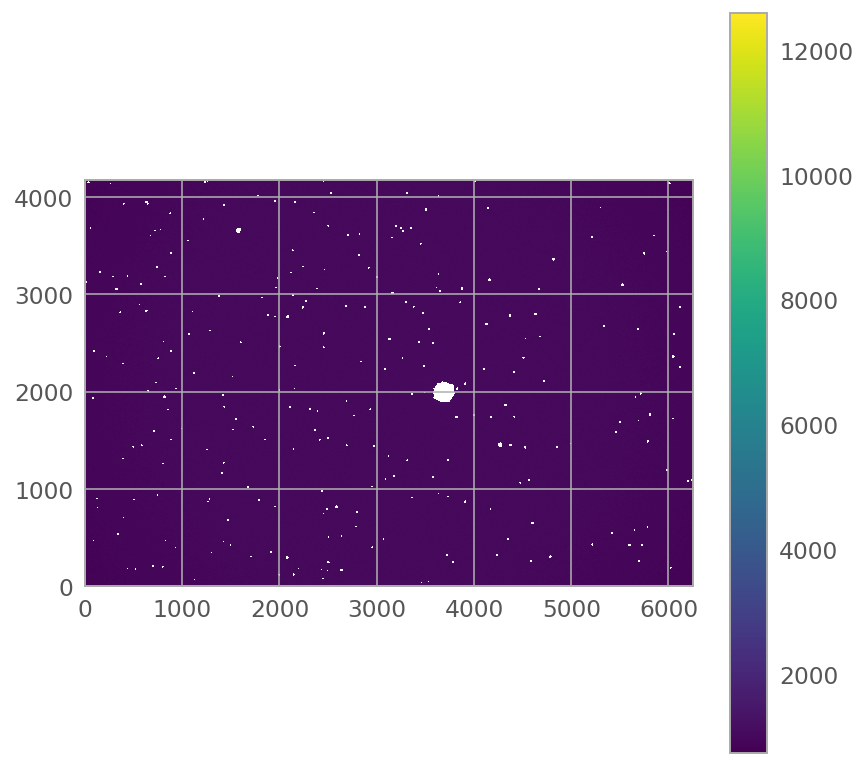

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_7605/2013415125.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar()


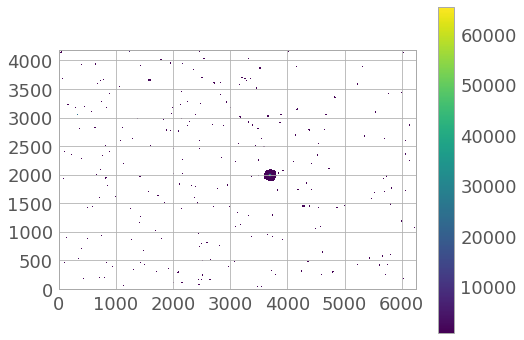

In [42]:

# SOURCE: https://photutils.readthedocs.io/en/stable/background.html

#just average estimate to characterise background
print('BRUTE FORCE: mean, median, std = {}, {}, {}'.format(np.mean(image_clean), np.median(image_clean), mad_std(img)))

# using clipped statistics to characterise background
mean, median, std = sigma_clipped_stats(image_clean, sigma=3.0)
print('CLIPPED: mean, median, std = {}, {}, {}'.format(mean, median, std))

# masking sources
mask = make_source_mask(image_clean, nsigma=3, npixels=5, dilate_size=11)
masked_image = np.ma.array(image_clean, mask=mask)
mean, median, std = sigma_clipped_stats(image_clean, sigma=3.0, mask=mask)
print('MASKED: mean, median, std = {}, {}, {}'.format(mean, median, std))
plt.figure(figsize=(7,7), dpi=140)
plt.imshow(masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
inverted_masked_image = np.ma.masked_where(np.logical_not(mask), image_clean)
plt.imshow(inverted_masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.show()

Calibrated min = 0.9726472086903307, max = 1.1607317702266642
Raw min = 0.8468988492934998, max = 1.0507920099735089


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_7605/3642837840.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar()


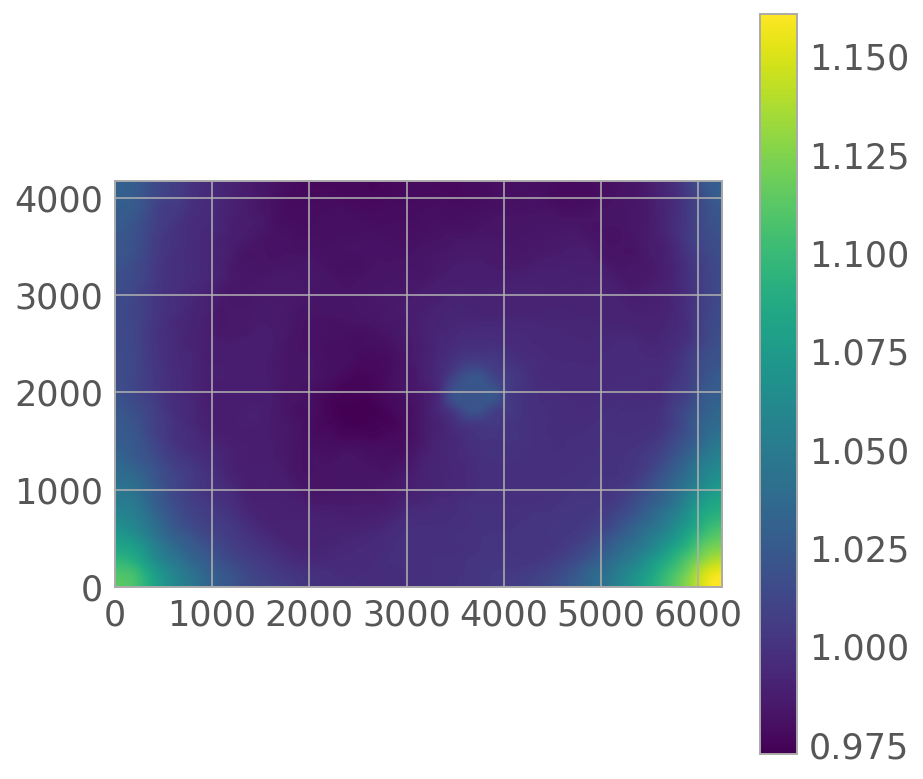

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_7605/3642837840.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar()


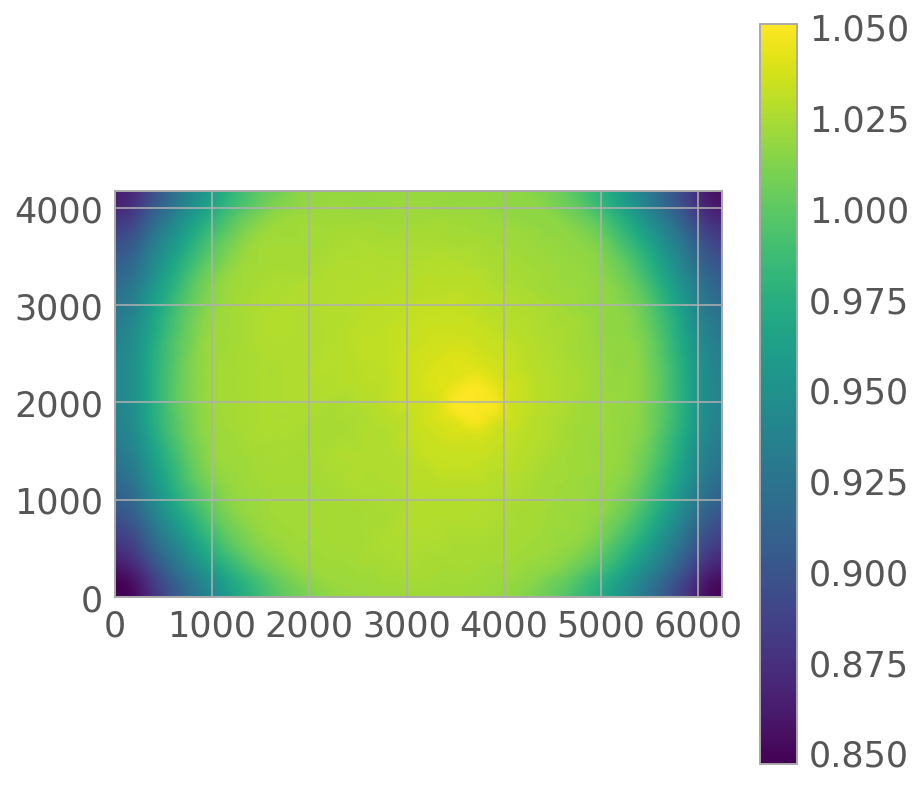

In [45]:
# Estimation of the 2D background value variation
sigma_clips = SigmaClip(sigma=4.0)
bkg_estimator = MedianBackground()
bkg = Background2D(image_clean, (116, 142), mask=mask, filter_size=(3,3), sigma_clip = sigma_clips, bkg_estimator=bkg_estimator)
bkg_uncalibrated = Background2D(img, (116, 142), mask=mask, filter_size=(3,3), sigma_clip=sigma_clips, bkg_estimator=bkg_estimator)

# normalisation
bkg.background /= np.mean(bkg.background)
bkg_uncalibrated.background /= np.mean(bkg_uncalibrated.background)

print('Calibrated min = {}, max = {}'.format(np.min(bkg.background), np.max(bkg.background)))
print('Raw min = {}, max = {}'.format(
    np.min(bkg_uncalibrated.background), np.max(bkg_uncalibrated.background)))


plt.figure(figsize=(7,7), dpi=140)
plt.imshow(bkg.background, origin='lower', cmap='viridis', interpolation='none')
cb = plt.colorbar()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb.ax.tick_params(labelsize=18)
plt.show()

plt.figure(figsize=(7,7), dpi=140)
plt.imshow(bkg_uncalibrated.background, origin='lower',
           cmap='viridis', interpolation='none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.show()


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_7605/2502607126.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


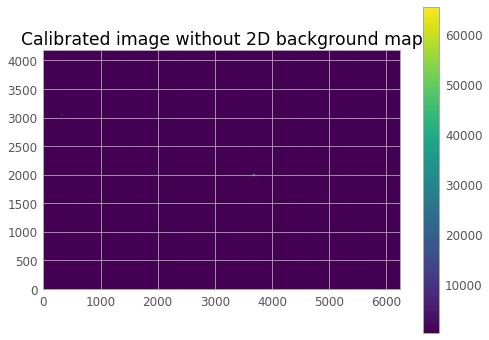

In [24]:
# image calibrated and with removed background

image_calibrated = image_clean - bkg.background
#image_calibrated = np.where(image_calibrated<0, 0, image_calibrated)
image_calibrated = -np.min(image_calibrated) + image_calibrated
plt.figure()
plt.title('Calibrated image without 2D background map')
plt.imshow(image_clean, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()
